Imports

In [35]:
import random
import numpy as np
import matplotlib.pyplot as plt
sample_size = 10

# Rules:
- If $\alpha$ = $\beta$ = 1 then we have uniform distribution
- If $\alpha$ = $\beta$     then we have a symmetric distribution, where x = 1/2
- If $\alpha$ > $\beta$     then the density is right-leaning (concentrated in the neighbourhood of 1) the mean and variance will be able to be computed explicitly

# Beta-density plots
Property 1: $\alpha = \beta = 1$

In [36]:
a1 = 1
b1 = 1
case_1 = [np.random.beta(a1, b1) for x in range(0, sample_size)]

Property 2: $\alpha = \beta \neq 1$

In [37]:
r = random.random()
while r == 1:
    r = random.random()
case_2 = [np.random.beta(r, r) for x in range(0, sample_size)]

Property 3: $\alpha > \beta$

In [38]:
a3 = 1
b3 = 1
while a3 <= b3:
    a3 = random.random()
    b3 = random.random()

case_3 = [np.random.beta(a3, b3) for x in range(0, sample_size)]

Property 4: Larger values of $\alpha$ and $\beta$ produce a more peaked distribution

In [39]:
a4 = 5 # Probably have to change this
b4 = 6

case_4 = [np.random.beta(a4, b4) for x in range(0, sample_size)]

Generating plots

In [40]:
x1 = [1 for x in range(0, sample_size)]
x2 = [2 for x in range(0, sample_size)]
x3 = [3 for x in range(0, sample_size)]
x4 = [4 for x in range(0, sample_size)]

Below we demonstrate the differences between the four properties explained above of the beta-distribution.

-   Case 1, where $\alpha = \beta = 1$, demonstrates a uniform distribution
-   Case 2, where $\alpha = \beta \neq 1$, demonstrates a symmetric distribution (concentrated towards limits)
-   Case 3, where $\alpha > \beta$, demonstrates a distribution concentrated toward the upper limit of 1
-   Case 4, where $\alpha$ and $\beta$ have large values, to get more peaked values (concentrated towards $\frac{1}{2}$)

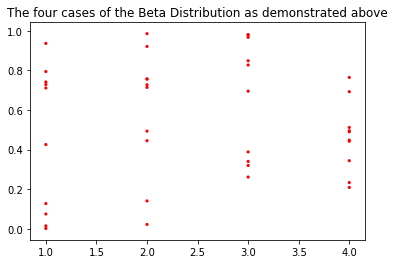

In [41]:
plt.scatter(x1+x2+x3+x4, case_1+case_2+case_3+case_4, alpha=1, c='red', edgecolors='none', s=10)
plt.title('The four cases of the Beta Distribution as demonstrated above')
plt.show()


# Thompson Update Rule

Computing the mean and variance of the Beta Distribution

In [42]:
def beta_mean(alpha: int, beta: int) -> float:
    return alpha / (alpha + beta)

def beta_var(alpha: int, beta: int) -> float:
    return (alpha * beta) / ((alpha + beta) ** 2) * (alpha + beta + 1)

Thompson Update Rule

In [43]:
# Get a Beta Distribution and applies the Thompson Update Rule
def thompson_update_rule(alpha: float = 1, beta: float = 1) -> (int, int):
    sample = np.random.beta(alpha, beta)              # Generate Probability
    reward = bandit_sample(sample)                    # Get reward
    return alpha+reward, beta+(1-reward)              # Amend Alpha and Beta values accordingly

Sample from a single arm, which gets a win/loss with probability $p$

In [44]:
# returns reward depending on sample passed
def bandit_sample(p: float) -> int:
    return 1 if p > random.random() else 0

Collecting data for a sample of $s = 10000$

In [45]:
s = 10
tuple_values = [(1, 1)]
means = []
std_s = []

# initial state of alpha and beta... will be updated by every iteration using Thompson rule
alpha = 1
beta = 1
means.append(beta_mean(alpha, beta))
std_s.append(beta_var(alpha, beta))

for _ in range(0, s):
    alpha, beta = thompson_update_rule(alpha, beta)
    tuple_values.append((alpha, beta))
    means.append(beta_mean(alpha, beta))
    std_s.append(beta_var(alpha, beta))
